In [1]:
import gymnasium as gym
import neat
import numpy as np
import matplotlib.pyplot as plt
import os
import pygraphviz as pgv
from PIL import Image
import imageio
import re

### Visualize winner 
Actually load in a checkpoint and see how the agent does using the environments render method

In [3]:
def visualize_winner(net, env, num_episodes=1):
    """ 
    Runs through a game to help visalize the policy
    """
    for _ in range(num_episodes):
        observation, _ = env.reset()
        total_reward = 0
        steps = 0
        done = False
        while not done:
            env.render()
            inputs = np.array(observation)
            output = net.activate(inputs)
            action = np.clip(output, -1, 1)
            observation, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            steps += 1
            done = terminated or truncated
        print(f"Episode completed with total reward: {total_reward} in {steps} steps.")
    env.close()

CONFIG_PATH = 'bipedal-neat-config.txt'
CONFIG = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     CONFIG_PATH)
CHECKPOINT = 398
checkpoint_path = f'checkpoints/bipedal/neat-checkpoint-{CHECKPOINT}'
pop = neat.Checkpointer.restore_checkpoint(checkpoint_path)
winner = max([g for g in pop.population.values() if g.fitness], key=lambda g: g.fitness)
winner_net = neat.nn.FeedForwardNetwork.create(winner, pop.config)
visualize_winner(winner_net, gym.make('BipedalWalker-v3', render_mode='human'))

Episode completed with total reward: 167.7318463111747 in 1600 steps.


: 

# Main Graph 
Generates a graph comparing the statistics of the NEAT vs NEAT-R runs by loading in checkpoints. 
TODO: It still takes a while so this can be optimized by further saving some of the data in seperate date files. 

Checkpoint checkpoints/bipedal/neat-checkpoint-111: Total Neurons = 5, Dormant Neurons = 1
Checkpoint checkpoints/bipedal/neat-checkpoint-323: Total Neurons = 1, Dormant Neurons = 0
Checkpoint checkpoints/bipedal/neat-checkpoint-129: Total Neurons = 5, Dormant Neurons = 1
Checkpoint checkpoints/bipedal/neat-checkpoint-324: Total Neurons = 2, Dormant Neurons = 0
Checkpoint checkpoints/bipedal/neat-checkpoint-116: Total Neurons = 6, Dormant Neurons = 0
Checkpoint checkpoints/bipedal/neat-checkpoint-312: Total Neurons = 2, Dormant Neurons = 0
Checkpoint checkpoints/bipedal/neat-checkpoint-120: Total Neurons = 4, Dormant Neurons = 1
Checkpoint checkpoints/bipedal/neat-checkpoint-118: Total Neurons = 7, Dormant Neurons = 1
Checkpoint checkpoints/bipedal/neat-checkpoint-127: Total Neurons = 7, Dormant Neurons = 0
Checkpoint checkpoints/bipedal/neat-checkpoint-315: Total Neurons = 1, Dormant Neurons = 0
Checkpoint checkpoints/bipedal/neat-checkpoint-341: Total Neurons = 1, Dormant Neurons = 0

/Users/johnwu/Documents/Brown CS/cs2951f_env/2951f-final/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/johnwu/Documents/Brown CS/cs2951f_env/2951f-final/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Checkpoint checkpoints/bipedal/neat-checkpoint-325: Total Neurons = 0, Dormant Neurons = 0
Checkpoint checkpoints/bipedal/neat-checkpoint-322: Total Neurons = 1, Dormant Neurons = 0
Checkpoint checkpoints/bipedal/neat-checkpoint-110: Total Neurons = 5, Dormant Neurons = 1
Checkpoint checkpoints/bipedal/neat-checkpoint-382: Total Neurons = 1, Dormant Neurons = 0
Checkpoint checkpoints/bipedal/neat-checkpoint-144: Total Neurons = 9, Dormant Neurons = 1
Checkpoint checkpoints/bipedal/neat-checkpoint-376: Total Neurons = 1, Dormant Neurons = 0
Checkpoint checkpoints/bipedal/neat-checkpoint-349: Total Neurons = 1, Dormant Neurons = 0
Checkpoint checkpoints/bipedal/neat-checkpoint-371: Total Neurons = 1, Dormant Neurons = 0
Checkpoint checkpoints/bipedal/neat-checkpoint-143: Total Neurons = 9, Dormant Neurons = 2
Checkpoint checkpoints/bipedal/neat-checkpoint-385: Total Neurons = 1, Dormant Neurons = 0
Checkpoint checkpoints/bipedal/neat-checkpoint-188: Total Neurons = 4, Dormant Neurons = 1

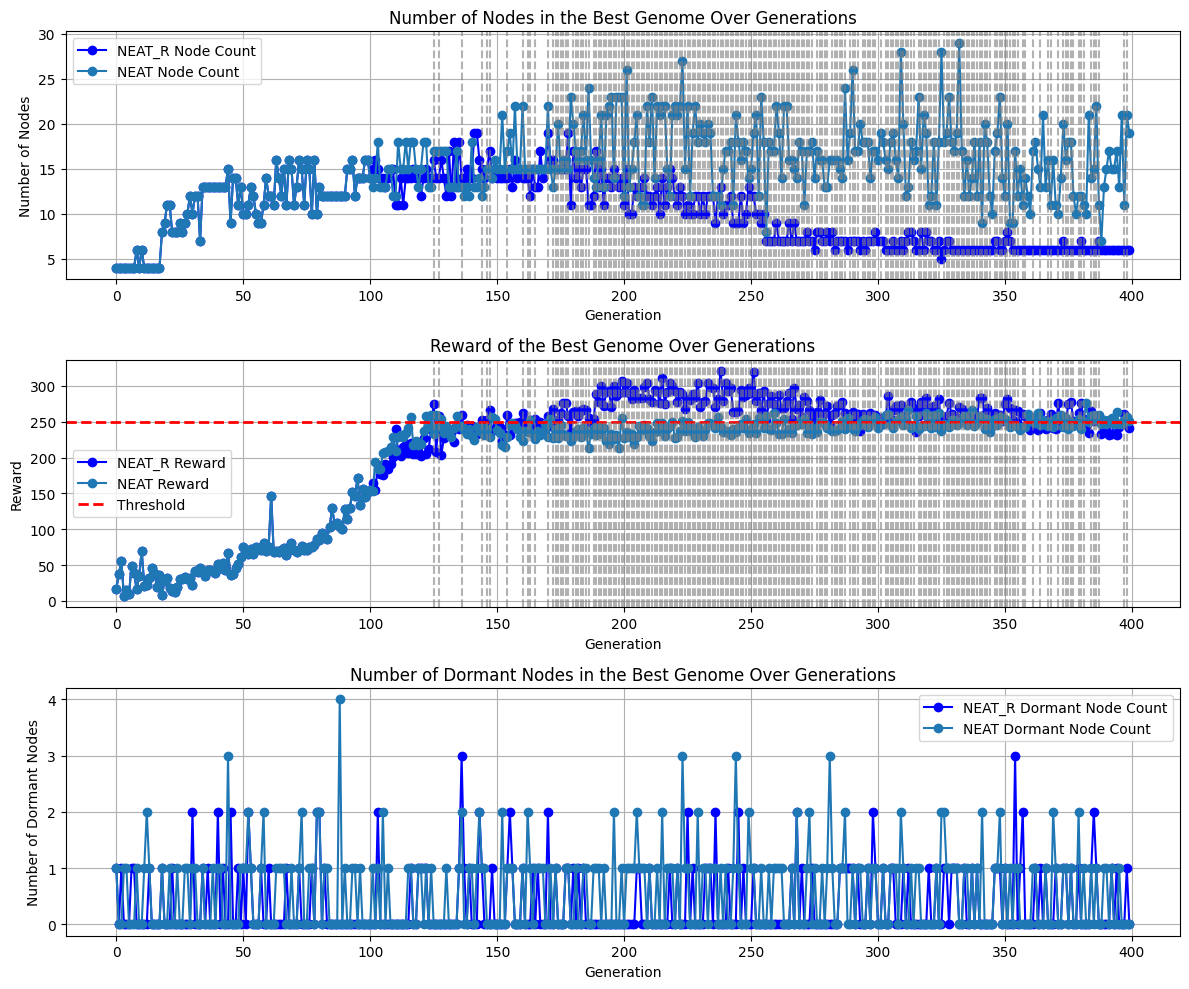

In [4]:
REWARD_THRESHOLD = 250
DORMANCY_THRESHOLD = 0
NUM_PENALTY = 0
NODE_PENALTY = 0.1

def load_checkpoint(checkpoint_path):
    return neat.Checkpointer.restore_checkpoint(checkpoint_path)

def extract_info_from_checkpoint(checkpoint_path, apply_penalty=True):
    """ 
    Recreates the total reward from checkpoint by calculating and adding back penalty
    """
    global NUM_PENALTY
    pop = load_checkpoint(checkpoint_path)
    best_genome = max([g for g in pop.population.values() if g.fitness], key=lambda g: g.fitness)
    num_nodes = len(best_genome.nodes)
    fitness = best_genome.fitness
    if apply_penalty:
        node_penalty = num_nodes * NODE_PENALTY * NUM_PENALTY
        if best_genome.fitness + node_penalty > REWARD_THRESHOLD:
            NUM_PENALTY += 1
        fitness += node_penalty
    return num_nodes, fitness

def get_checkpoint_files(dir_path):
    "Makes sure to actually load in checkpoint files in numerical order"
    return [os.path.join(dir_path, f) for f in sorted(os.listdir(dir_path), key=lambda x: int(re.search(r'\d+', x).group())) if f.startswith('neat-checkpoint-')]

env = gym.make('BipedalWalker-v3', render_mode='rgb_array')

def eval_genome(genome, config):
    """ 
    Copied from NEAT to capture all output
    """
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    observation, _ = env.reset()
    all_node_outputs = []
    done = False
    while not done:
        net.activate(observation)
        node_outputs = [net.values[i] for i in net.values.keys() if i in genome.nodes and i not in net.output_nodes] 
        all_node_outputs.append(np.abs(node_outputs))
        action = [net.values[i] for i in net.output_nodes]
        observation, _, terminated, truncated, _ = env.step(np.clip(action, -1, 1))
        done = terminated or truncated
    env.close()
    return np.array(all_node_outputs)

def calculate_activity_scores(checkpoint_dir):
    """ 
    Reruns through the saved network and captures all output from every generation to calculate dormancy 
    """
    checkpoint_files = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if 'neat-checkpoint-' in f]
    dormant_neuron_list = []
    for checkpoint_file in checkpoint_files:
        pop = neat.Checkpointer.restore_checkpoint(checkpoint_file)
        genome = max(pop.population.values(), key=lambda g: g.fitness if g.fitness is not None else -float('inf'))
        all_node_outputs = eval_genome(genome, CONFIG)
        mean_activity = np.mean(all_node_outputs, axis=0)
        avg_activity = np.mean(mean_activity)
        activity_scores = mean_activity / avg_activity
        dormant_neurons = np.sum(activity_scores <= DORMANCY_THRESHOLD) 
        print(f"Checkpoint {checkpoint_file}: Total Neurons = {len(mean_activity)}, Dormant Neurons = {dormant_neurons}")
        dormant_neuron_list.append(dormant_neurons)
    return dormant_neuron_list

bipedal_dir = 'checkpoints/bipedal'
bipedal_standard_dir = 'checkpoints/bipedal standard'
bipedal_files = get_checkpoint_files(bipedal_dir)
dormant_node_files = calculate_activity_scores(bipedal_dir)
bipedal_standard_files = get_checkpoint_files(bipedal_standard_dir)
std_dormant_node_files = calculate_activity_scores(bipedal_standard_dir)


num_nodes_over_generations = []
dormant_nodes_over_generations = []
adjusted_rewards_over_generations = []
raw_num_nodes_over_generations = []
raw_dormant_nodes_over_generations = []
raw_rewards_over_generations = []

for f, fs, dormant_nodes, raw_dormant_nodes in zip(bipedal_files, bipedal_standard_files, dormant_node_files, std_dormant_node_files):
    nodes, adjusted_reward = extract_info_from_checkpoint(f)
    raw_nodes, raw_reward = extract_info_from_checkpoint(fs, apply_penalty=False)
    
    num_nodes_over_generations.append(nodes)
    dormant_nodes_over_generations.append(dormant_nodes)
    raw_num_nodes_over_generations.append(raw_nodes)
    raw_dormant_nodes_over_generations.append(raw_dormant_nodes)
    adjusted_rewards_over_generations.append(adjusted_reward)
    raw_rewards_over_generations.append(raw_reward)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))


ax1.plot(num_nodes_over_generations, marker='o', linestyle='-', color='blue', label='NEAT_R Node Count')
ax1.plot(raw_num_nodes_over_generations, marker='o', linestyle='-', label='NEAT Node Count')
ax1.set_title("Number of Nodes in the Best Genome Over Generations")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Number of Nodes")
ax1.grid(True)
ax1.legend()

ax2.plot(adjusted_rewards_over_generations, marker='o', linestyle='-', color='blue', label='NEAT_R Reward')
ax2.plot(raw_rewards_over_generations, marker='o', linestyle='-', label='NEAT Reward')
ax2.set_title("Reward of the Best Genome Over Generations")
ax2.set_xlabel("Generation")
ax2.set_ylabel("Reward")
ax2.grid(True)
ax2.axhline(y=REWARD_THRESHOLD, color='red', linestyle='--', linewidth=2, label='Threshold')
ax2.legend()

ax3.plot(dormant_nodes_over_generations, marker='o', linestyle='-', color='blue', label='NEAT_R Dormant Node Count')
ax3.plot(raw_dormant_nodes_over_generations, marker='o', linestyle='-', label='NEAT Dormant Node Count')
ax3.set_title("Number of Dormant Nodes in the Best Genome Over Generations")
ax3.set_xlabel("Generation")
ax3.set_ylabel("Number of Dormant Nodes")
ax3.grid(True)
ax3.legend()

for i, reward in enumerate(adjusted_rewards_over_generations):
    if reward > REWARD_THRESHOLD:
        ax1.axvline(x=i, color='grey', linestyle='--', alpha=0.6)
        ax2.axvline(x=i, color='grey', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### Visualize Network 
Uses pygraph to capture the network at every generation by koading in checkpoints, then saves those images and unifies them into a gif

In [13]:
def visualize_network(genome, config, filename='winner_network', node_names=None):
    if node_names is None:
        node_names = {} 

    # Pygraph stylization of the nodes for a visualization 
    g = pgv.AGraph(directed=True)
    g.graph_attr['rankdir'] = 'LR'
    node_attrs = {
        'shape': 'circle',
        'fixedsize': 'true',
        'width': '1.2',  
        'height': '1.2',
        'style': 'filled',
    }
    
    # Add all of the nodes to the visualization colorizing them to be either input output or not either
    for node_id in set(list(genome.nodes.keys()) + config.genome_config.input_keys + config.genome_config.output_keys):
        # print(node_id)
        if node_id in node_names:
            node_label = node_names[node_id]
        else: 
            node_label = str(node_id)
        
        node_color = 'grey'
        if node_id in config.genome_config.input_keys:
            node_color = 'green'  
        elif node_id in config.genome_config.output_keys:
            node_color = 'red' 
        g.add_node(node_label, color=node_color, **node_attrs)

    # Add in all the edges -> Change Weight to be a reasonable amount of decimal points to still look clean
    for cg in genome.connections.values():
        # print(cg.key)
        in_node_label = node_names.get(cg.key[0], str(cg.key[0]))
        out_node_label = node_names.get(cg.key[1], str(cg.key[1]))
        weight = round(cg.weight, 2)
        g.add_edge(in_node_label, out_node_label, label=weight, color="gray" if weight >= 0 else "red")
    
    g.layout(prog='dot')
    g.draw(f'{filename}')
    print(f"Network graph saved as {filename}")

def generate_images_for_checkpoints(checkpoint_dir, output_dir):
    "Saves all the visualizations to a image directory to be saved in a gif later"
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith('neat-checkpoint-')]
    checkpoints.sort()

    for checkpoint_file in checkpoints:
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
        pop = neat.Checkpointer.restore_checkpoint(checkpoint_path)
        winner = max(pop.population.values(), key=lambda g: g.fitness if g.fitness is not None else -float('inf'))
        filename = os.path.join(output_dir, f"network_{checkpoint_file}.png")
        # Only check to see the network of the winner
        visualize_network(winner, pop.config, filename)

def resize_images_with_padding(input_directory):
    """
    MAKES all the images the same shape so they can actually be gifified 
    """
    max_width, max_height = 0, 0
    image_paths = [os.path.join(input_directory, f) for f in os.listdir(input_directory) if f.endswith('.png')]

    for path in image_paths:
        with Image.open(path) as img:
            width, height = img.size
            max_width = max(max_width, width)
            max_height = max(max_height, height)

    for path in image_paths:
        with Image.open(path) as img:
            width, height = img.size

            new_img = Image.new('RGB', (max_width, max_height), 'white')
            upper_x = (max_width - width) // 2
            upper_y = (max_height - height) // 2
            new_img.paste(img, (upper_x, upper_y))
            new_img.save(path)
            print(f'Resized and saved {path}')

def create_gif(image_folder, output_gif_name, duration=1):
    "Combines the series of images to make a fig"
    images = []
    file_paths = [os.path.join(image_folder, file_name) for file_name in sorted(os.listdir(image_folder), key=lambda x: int(re.search(r'\d+', x).group())) if file_name.endswith('.png')]
    
    for file_path in file_paths:
        print(file_path)
        images.append(imageio.imread(file_path))
    
    imageio.mimsave(output_gif_name, images, duration=duration)

# Weird path stuff having to do with graphviz working in venvs but still needing global homebrew stuff
os.environ["PATH"] += os.pathsep + '/opt/homebrew/bin'

checkpoint_dir = './checkpoints/bipedal'
output_dir = './network_images'
os.makedirs(output_dir, exist_ok=True)
generate_images_for_checkpoints(checkpoint_dir, output_dir)
resize_images_with_padding(output_dir)
create_gif(output_dir, "Bipedal-network.gif", duration=1)

Network graph saved as ./network_images/network_neat-checkpoint-0.png.png
Network graph saved as ./network_images/network_neat-checkpoint-1.png.png
Network graph saved as ./network_images/network_neat-checkpoint-10.png.png
Network graph saved as ./network_images/network_neat-checkpoint-100.png.png
Network graph saved as ./network_images/network_neat-checkpoint-101.png.png
Network graph saved as ./network_images/network_neat-checkpoint-102.png.png
Network graph saved as ./network_images/network_neat-checkpoint-103.png.png
Network graph saved as ./network_images/network_neat-checkpoint-104.png.png
Network graph saved as ./network_images/network_neat-checkpoint-105.png.png
Network graph saved as ./network_images/network_neat-checkpoint-106.png.png
Network graph saved as ./network_images/network_neat-checkpoint-107.png.png
Network graph saved as ./network_images/network_neat-checkpoint-108.png.png
Network graph saved as ./network_images/network_neat-checkpoint-109.png.png
Network graph sav

/var/folders/jw/6ndvyxwn0z13_8v9fm01bpc80000gn/T/ipykernel_15606/1657715970.py:91: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


./network_images/network_neat-checkpoint-2.png
./network_images/network_neat-checkpoint-3.png
./network_images/network_neat-checkpoint-4.png
./network_images/network_neat-checkpoint-5.png
./network_images/network_neat-checkpoint-6.png
./network_images/network_neat-checkpoint-7.png
./network_images/network_neat-checkpoint-8.png
./network_images/network_neat-checkpoint-9.png
./network_images/network_neat-checkpoint-10.png
./network_images/network_neat-checkpoint-11.png
./network_images/network_neat-checkpoint-12.png
./network_images/network_neat-checkpoint-13.png
./network_images/network_neat-checkpoint-14.png
./network_images/network_neat-checkpoint-15.png
./network_images/network_neat-checkpoint-16.png
./network_images/network_neat-checkpoint-17.png
./network_images/network_neat-checkpoint-18.png
./network_images/network_neat-checkpoint-19.png
./network_images/network_neat-checkpoint-20.png
./network_images/network_neat-checkpoint-21.png
./network_images/network_neat-checkpoint-22.png


Bad pipe message: %s [b'\xd3E\xd6\x15\x9e\xf3\xa7\xc2\x1f\xe5\xa5\xd8\xb9V\xac\x1c\x1e\x9e \xf7B\x9fK\xbd\xd9\xe7\x84\x1dV\xa8Wq\x8c&\x97[\xe6A\xa9\xf6\xb4\xc7\x14\xeb+\x90\xcc\t\xa5\xe5\r\x00 **\x13\x01\x13\x02\x13\x03\xc0+\xc0/\xc0,\xc00\xcc\xa9\xcc\xa8\xc0\x13\xc0\x14\x00\x9c\x00\x9d\x00/\x005\x01\x00\x06\x93zz\x00\x00\x00\r\x00\x12\x00\x10\x04\x03\x08\x04\x04\x01\x05\x03\x08\x05\x05\x01\x08\x06\x06\x01\x00#\x00\x00\x00\x12\x00\x00\x00\x10\x00\x0e\x00\x0c\x02h2\x08http/1.1\x003\x04\xef\x04\xed\xca\xca\x00\x01\x00c\x99']
Bad pipe message: %s [b'\x89!%']
Bad pipe message: %s [b'\xfa\xeeV']
Bad pipe message: %s [b'\xb3\x19{\n\x1d\xb4M\xdfsoZ\x8fV\xd1\xf0\x8b\xd5(\x9e=%~5\x98\xb4\xf8']
Bad pipe message: %s [b"\xba9Pk\xd9\x83\xae\x88\xa9\xee\x19\xb5IT\x1fLY\x86\xa64,\xd2\x01,E\xa0GSsV\xca,0\xc9\xcb\x12BL!\xc5'nX\xd5\xb7\x89\xdc$\xb5zvc{\xb0H\xb8@\x066\xa7\xee\xcc\x10\xab\xb7Am\xba}\xef\x998\xa6P\xc3\xb5\x90\xc3d\xe5"]
